# **Libraries**

In [ ]:
!pip install breaching

import torch
import torchvision
import breaching
import math
import json
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from numbers import Number
from google.colab import drive
from PIL import Image
from torchvision import datasets, models, transforms
from collections import OrderedDict
from skimage.metrics import structural_similarity as ssim

drive.mount('/content/drive')

In [ ]:
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    max_pixel = 1.0
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))

## **Net Arch**

In [ ]:
class ConvNet(torch.nn.Module):
    """ConvNetBN."""

    def __init__(self, width=32, num_classes=2, num_channels=3):
        """Init with width and num classes."""
        super().__init__()
        self.model = torch.nn.Sequential(OrderedDict([
            ('conv0', torch.nn.Conv2d(num_channels, 1 * width, kernel_size=3, padding=1)),
            ('bn0', torch.nn.BatchNorm2d(1 * width)),
            ('relu0', torch.nn.ReLU()),

            ('conv1', torch.nn.Conv2d(1 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn1', torch.nn.BatchNorm2d(2 * width)),
            ('relu1', torch.nn.ReLU()),

            ('conv2', torch.nn.Conv2d(2 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn2', torch.nn.BatchNorm2d(2 * width)),
            ('relu2', torch.nn.ReLU()),

            ('pool1', torch.nn.MaxPool2d(3)),
            ('flatten', torch.nn.Flatten()),
            #('var_bottleneck', VariationalBottleneck((10952 * width,))),
            ('linear', torch.nn.Linear(10952  * width, num_classes))
        ]))

    def forward(self, input):
        return self.model(input)

model = ConvNet()
model.to('cuda:0')
model.eval()
criterion = nn.CrossEntropyLoss().cuda();

## **Data loading/settings**

In [ ]:
class data_cfg_default:
    modality = "vision"
    size = (5216,)
    classes = 2
    shape = (3, 224, 224)
    normalize = False #Normalization comes in the dataloaders
    mean = (0.4794, 0.4794, 0.4794)
    std =  (0.2384, 0.2384, 0.2384)

unnormalize = transforms.Normalize(
                        mean=[-0.4794/0.2384, -0.4794/0.2384, -0.4794/0.2384],
                        std=[1/0.2384, 1/0.2384, 1/0.2384])

In [ ]:
batch_size = 8
data_dir = {
            'train': '/content/drive/MyDrive/Colab Notebooks/chest_xray/train',
            'test': '/content/drive/MyDrive/Colab Notebooks/chest_xray/test',
            'valid': '/content/drive/MyDrive/Colab Notebooks/chest_xray/val',
            }

data_transforms = {
            'train': transforms.Compose([
                        transforms.Resize((224, 224)),
                        #transforms.CenterCrop(224),
                        #transforms.RandomHorizontalFlip(), # randomly flip and rotate
                        #transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        transforms.Normalize((0.4794, 0.4794, 0.4794), (0.2384, 0.2384, 0.2384)),
                    ]),

            'test': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ]),

            'valid': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            }

In [ ]:
data_set={
        'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
        'test': torchvision.datasets.ImageFolder(data_dir['test'], data_transforms['test']),
        'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
         }

data_loader={
        'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size,shuffle=True),
        'test': torch.utils.data.DataLoader(data_set['test'], batch_size=batch_size,shuffle=False),
        'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batch_size,shuffle=False),
        }

## **Attack config**

* Loading specifications and hyperparms for the scenario and attacker of the reconstruction

In [2]:
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
setup = dict(device=device, dtype=getattr(torch, 'float'))

attack_conf = json.load(open("attack_config.txt"))
attack_conf = dict_properties(attack_conf)

user_conf = json.load(open("user_config.txt"))
user_conf = dict_properties(user_conf)

* Simulate an attacked FL protocol: Server-side computation (executing a number of local epochs)


In [ ]:
user = UserMultiStep(model, criterion, data_loader['train'], setup, 1, user_conf)
server_payload = [dict(parameters=[p for p in model.parameters()], buffers=[b for b in model.buffers()], metadata=data_cfg_default)]
shared_data, true_user_data = user.compute_local_updates(server_payload)

* Launch the attack

In [ ]:
attacker = OptimizationBasedAttacker(model, criterion, cfg_attack, setup)
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=False)

| It: 1 | Rec. loss: 0.3233 |  Task loss: 0.0016 | T: 0.30s
| It: 251 | Rec. loss: 0.0009 |  Task loss: 0.0550 | T: 59.01s
| It: 501 | Rec. loss: 0.0007 |  Task loss: 0.0555 | T: 57.68s
| It: 751 | Rec. loss: 0.0007 |  Task loss: 0.0558 | T: 58.28s
| It: 1001 | Rec. loss: 0.0007 |  Task loss: 0.0560 | T: 57.77s
| It: 1251 | Rec. loss: 0.0006 |  Task loss: 0.0560 | T: 57.77s
| It: 1501 | Rec. loss: 0.0006 |  Task loss: 0.0560 | T: 57.64s
| It: 1751 | Rec. loss: 0.0006 |  Task loss: 0.0560 | T: 57.94s
| It: 2001 | Rec. loss: 0.0006 |  Task loss: 0.0559 | T: 57.79s
| It: 2251 | Rec. loss: 0.0006 |  Task loss: 0.0561 | T: 57.84s
| It: 2501 | Rec. loss: 0.0006 |  Task loss: 0.0560 | T: 57.80s
| It: 2751 | Rec. loss: 0.0006 |  Task loss: 0.0560 | T: 57.79s
| It: 3001 | Rec. loss: 0.0006 |  Task loss: 0.0561 | T: 57.78s
Recovery interrupted manually in iteration 3173!


## **Plotting the results**
*Prepared for two recovered images*

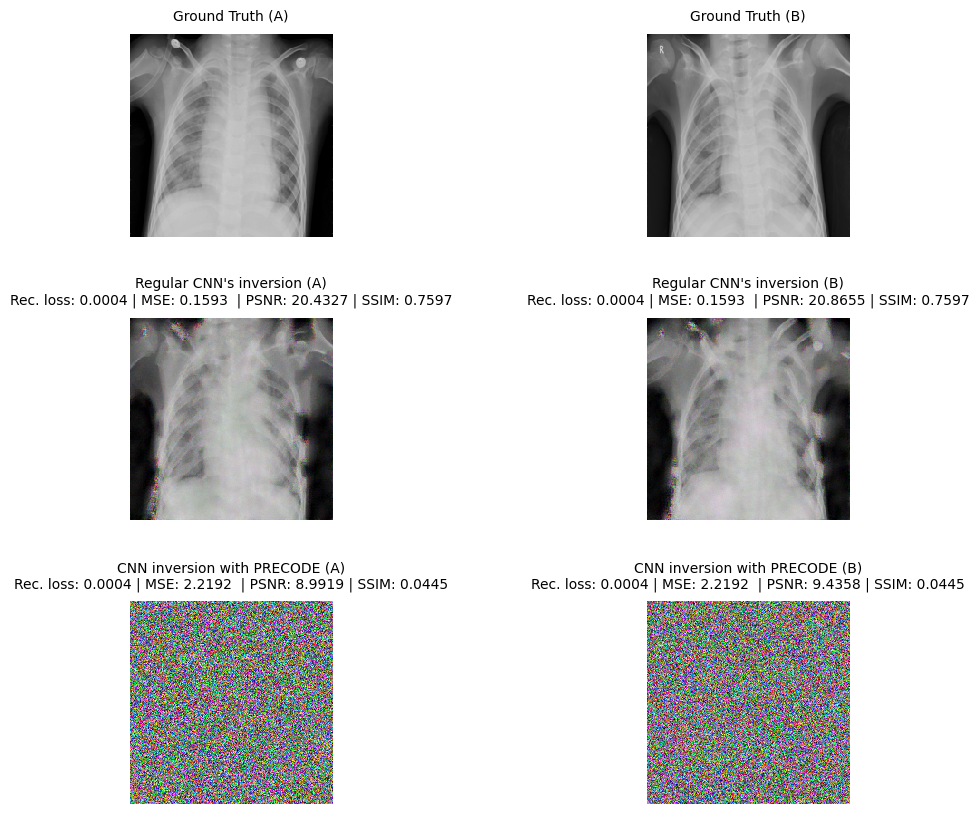

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(wspace=1, hspace=0.4)

for i, ax in enumerate(axes.flat):
    if i == 0:
        img = unnormalize(true_user_data['data'][0]).squeeze(0).permute(1, 2, 0)
        title = "Ground Truth (A)"
    elif i == 1:
        img = unnormalize(true_user_data['data'][1]).squeeze(0).permute(1, 2, 0)
        title = "Ground Truth (B)"
    elif i == 2:
        img = unnormalize(reconstructed_user_data['data'][0]).squeeze(0).permute(1, 2, 0)
        mse = (reconstructed_user_data['data'][0].detach() - true_user_data['data'][0]).pow(2).mean()
        psnr1 = psnr(unnormalize(reconstructed_user_data['data'][0]).squeeze(0).permute(1, 2, 0), unnormalize(true_user_data['data'][0]).squeeze(0).permute(1, 2, 0))
        ssim_score = ssim(img.cpu().numpy(), unnormalize(true_user_data['data'][0]).squeeze(0).permute(1, 2, 0).cpu().numpy(), channel_axis=2)
        title = f"Regular CNN's inversion (A)\nRec. loss: {stats['opt_value']:2.4f} | MSE: {mse:2.4f}  | PSNR: {psnr1:2.4f} | SSIM: {ssim_score:2.4f}"
    elif i == 3:
        img = unnormalize(reconstructed_user_data['data'][1]).squeeze(0).permute(1, 2, 0)
        mse_vb = (reconstructed_user_data['data'][1].detach() - true_user_data['data'][1]).pow(2).mean()
        psnr_vb = psnr(unnormalize(reconstructed_user_data['data'][1]).squeeze(0).permute(1, 2, 0), unnormalize(true_user_data['data'][1]).squeeze(0).permute(1, 2, 0))
        ssim_score_vb = ssim(img.cpu().numpy(), unnormalize(true_user_data['data'][1]).squeeze(0).permute(1, 2, 0).cpu().numpy(), channel_axis=2)
        title = f"Regular CNN's inversion (B)\nRec. loss: {stats['opt_value']:2.4f} | MSE: {mse:2.4f}  | PSNR: {psnr_vb:2.4f} | SSIM: {ssim_score:2.4f}"
    # elif i == 4:
    #     img = unnormalize(reconstructed_user_data_vb['data'][0]).squeeze(0).permute(1, 2, 0)
    #     mse = (reconstructed_user_data_vb['data'][0].detach() - true_user_data['data'][0]).pow(2).mean()
    #     psnr1 = psnr(unnormalize(reconstructed_user_data_vb['data'][0]).squeeze(0).permute(1, 2, 0), unnormalize(true_user_data['data'][0]).squeeze(0).permute(1, 2, 0))
    #     ssim_score = ssim(img.cpu().numpy(), unnormalize(true_user_data['data'][0]).squeeze(0).permute(1, 2, 0).cpu().numpy(), channel_axis=2)
    #     title = f"CNN inversion with PRECODE (A)\nRec. loss: {stats['opt_value']:2.4f} | MSE: {mse:2.4f}  | PSNR: {psnr1:2.4f} | SSIM: {ssim_score:2.4f}"
    # elif i == 5:
    #     img = unnormalize(reconstructed_user_data_vb['data'][1]).squeeze(0).permute(1, 2, 0)
    #     mse_vb = (reconstructed_user_data_vb['data'][1].detach() - true_user_data['data'][1]).pow(2).mean()
    #     psnr_vb = psnr(unnormalize(reconstructed_user_data_vb['data'][1]).squeeze(0).permute(1, 2, 0), unnormalize(true_user_data['data'][1]).squeeze(0).permute(1, 2, 0))
    #     ssim_score_vb = ssim(img.cpu().numpy(), unnormalize(true_user_data['data'][1]).squeeze(0).permute(1, 2, 0).cpu().numpy(), channel_axis=2)
    #     title = f"CNN inversion with PRECODE (B)\nRec. loss: {stats['opt_value']:2.4f} | MSE: {mse:2.4f}  | PSNR: {psnr_vb:2.4f} | SSIM: {ssim_score:2.4f}"

    ax.imshow(img.cpu().numpy(), interpolation='nearest')
    ax.set_title(title, fontsize=10, pad=10)
    ax.axis("off")

plt.show()